# <p><center style="font-family:newtimeroman;font-size:180%;">LLM Detect AI Generated Text </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Text Cleaning](#3)
* [Text Vectorization](#4)
* [TransformerBlock Model](#10)
* [Evaluate The Model](#11)
* [Submission](#12)

**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import tensorflow_text as tf_text
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras import Model, Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Read Data </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [2]:
train=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [3]:
test=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [4]:
train_prompts=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [5]:
train['prompt_id'].value_counts()

prompt_id
0    708
1    670
Name: count, dtype: int64

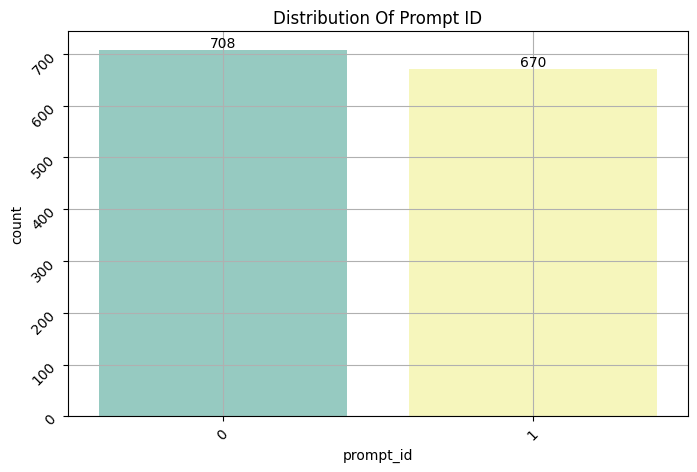

In [6]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train,x="prompt_id",palette='Set3')
abs_values = train['prompt_id'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Prompt ID")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [7]:
train['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

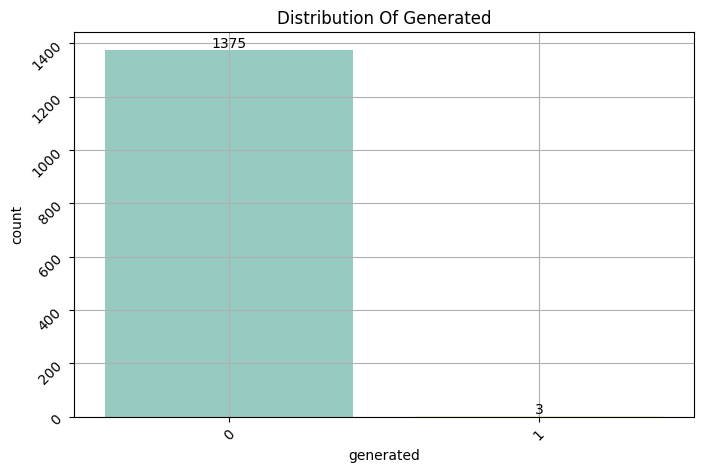

In [8]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train,x="generated",palette='Set3')
abs_values = train['generated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Generated")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [9]:
new_data=pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')
new_data.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [10]:
new_data.label.value_counts()

label
0    27371
1    17497
Name: count, dtype: int64

In [11]:
train_prompts.prompt_name.value_counts()

prompt_name
Car-free cities                     1
Does the electoral college work?    1
Name: count, dtype: int64

In [12]:
new_data.prompt_name.value_counts()

prompt_name
Distance learning                        5554
Seeking multiple opinions                5176
Car-free cities                          4717
Does the electoral college work?         4434
Facial action coding system              3084
Mandatory extracurricular activities     3077
Summer projects                          2701
Driverless cars                          2250
Exploring Venus                          2176
Cell phones at school                    2119
Grades for extracurricular activities    2116
Community service                        2092
"A Cowboy Who Rode the Waves"            1896
The Face on Mars                         1893
Phones and driving                       1583
Name: count, dtype: int64

In [13]:
new_=new_data.iloc[:, 0:2][new_data['prompt_name'].isin(train_prompts['prompt_name'].values)]
new_

,text,label
1168,Cars have been around for awhile and they have...,0
1169,Have you ever thought what it would be like no...,0
1170,What you are about to read is going to give yo...,0
1171,cars have many flaws nd and in this day and ag...,0
1172,There are many advantages of limiting car usag...,0
...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1
44864,"Dear Senator,\n\nI am writing to you today to ...",1
44865,"Dear Senator,\n\nI am writing to you today to ...",1
44866,"Dear Senator,\n\nI am writing to you today to ...",1


In [14]:
t=train.iloc[:,2:]
t.columns=['text','label']
train_data=pd.concat([new_,t])
train_data=train_data.reset_index().iloc[:,1:]
train_data.head()

,text,label
0,Cars have been around for awhile and they have...,0
1,Have you ever thought what it would be like no...,0
2,What you are about to read is going to give yo...,0
3,cars have many flaws nd and in this day and ag...,0
4,There are many advantages of limiting car usag...,0


In [15]:
train_data.label.value_counts()

label
0    6755
1    3774
Name: count, dtype: int64

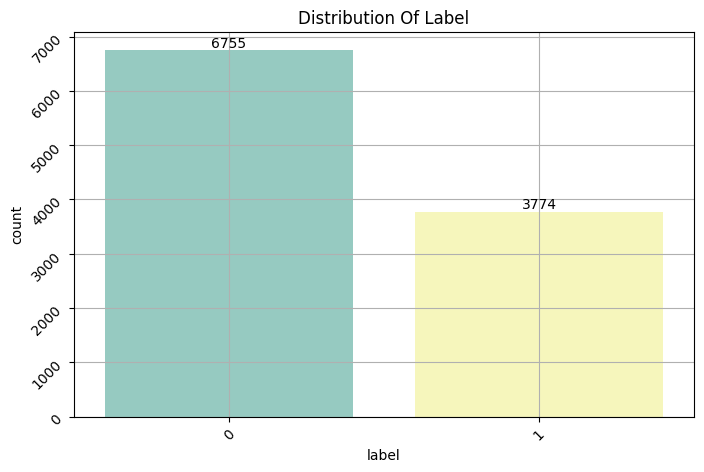

In [16]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train_data,x="label",palette='Set3')
abs_values = train_data['label'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Label")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Text Cleaning </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [17]:
def Clean(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.regex_replace(text, '\.\.\.', ' ')
    text = tf.strings.join(['',text, ''], separator=' ')
    return text
def clean_text(text):
    # Remove Twitter handles starting with '@'
    text = re.sub(r'@\w+', '', text)
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [18]:
train_data['text'][0]

'Cars have been around for awhile and they have had a major impact on society. Many people believe that there is no problem with the frequency of cars being driven. But, there are many advantages to less car use such as improving our cities and suburbs, improving safety, and decreasing pollution.\n\nMany have tried to make cities a little more dense and better for walking but nothing has seemed to work; therefore, they have moved on to suburbs. Now, people are trying to make suburbs better for getting around while walking instead of driving. By doing so, places such as shops will be made closer and more convienent which allows people to be able to consider walking as a better option. By having these suburbs, and soon hopefully cities, reduce the amount of cars used, the people living in these areas will be able to accomplish more in a healthier and safer way.\n\nSafety has been an issue in almost all areas due to a variety of reasons; one being cars. People pass by "Drive Safely" signs

In [19]:
Clean(train_data['text'][0])

<tf.Tensor: shape=(), dtype=string, numpy=b' cars have been around for awhile and they have had a major impact on society .  many people believe that there is no problem with the frequency of cars being driven .  but ,  there are many advantages to less car use such as improving our cities and suburbs ,  improving safety ,  and decreasing pollution . many have tried to make cities a little more dense and better for walking but nothing has seemed to work therefore ,  they have moved on to suburbs .  now ,  people are trying to make suburbs better for getting around while walking instead of driving .  by doing so ,  places such as shops will be made closer and more convienent which allows people to be able to consider walking as a better option .  by having these suburbs ,  and soon hopefully cities ,  reduce the amount of cars used ,  the people living in these areas will be able to accomplish more in a healthier and safer way . safety has been an issue in almost all areas due to a vari

In [20]:
clean_text(train_data['text'][0])

'cars have been around for awhile and they have had a major impact on society many people believe that there is no problem with the frequency of cars being driven but there are many advantages to less car use such as improving our cities and suburbs improving safety and decreasing pollution many have tried to make cities a little more dense and better for walking but nothing has seemed to work therefore they have moved on to suburbs now people are trying to make suburbs better for getting around while walking instead of driving by doing so places such as shops will be made closer and more convienent which allows people to be able to consider walking as a better option by having these suburbs and soon hopefully cities reduce the amount of cars used the people living in these areas will be able to accomplish more in a healthier and safer way safety has been an issue in almost all areas due to a variety of reasons one being cars people pass by drive safely signs or memorials on the side o

**<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Text Vectorization</p>
<a class="btn" href="#home">Tabel of Contents</a>

In [21]:
max_features = 75000
embedding_dim = 64
sequence_length = 512*2
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=Clean ,
    max_tokens=max_features,
    ngrams = (3,5),
    output_mode="int",
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True
)
vectorize_layer.adapt(train_data['text'])
Text = vectorize_layer(train_data['text']).numpy()
Text

array([[ 1138, 19101,  5729, ...,     1,     1,     1],
       [ 3796, 10859,     1, ...,     0,     0,     0],
       [28184,     1, 53697, ...,     1,     1,     1],
       ...,
       [    1, 31053,     1, ...,     1,     1,     1],
       [24714,  8587,     1, ...,     1,     1,     1],
       [ 1138, 19101, 21592, ...,     0,     0,     0]])

In [22]:
sm = SMOTE(random_state=44)
Text,labels= sm.fit_resample(Text,train_data['label'])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(Text,labels, test_size=0.2, random_state=44, shuffle =True,stratify=labels)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (10808, 1024)
X_test shape is  (2702, 1024)
y_train shape is  (10808,)
y_test shape is  (2702,)


**<a id="10"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">TransformerBlock Model</p>
<a class="btn" href="#home">Tabel of Contents</a>

In [24]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
inputs = Input(shape=(sequence_length,), dtype="int64")
x = Embedding(max_features, embedding_dim)(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
transformer_block = TransformerBlock(embedding_dim, 2, 32)
x = transformer_block(x)
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 embedding (Embedding)       (None, 1024, 64)          4800000   
                                                                 
 bidirectional (Bidirection  (None, 1024, 64)          24832     
 al)                                                             
                                                                 
 transformer_block (Transfo  (None, 1024, 64)          37664     
 rmerBlock)                                                      
                                                                 
 conv1d (Conv1D)             (None, 340, 128)          57472     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0     

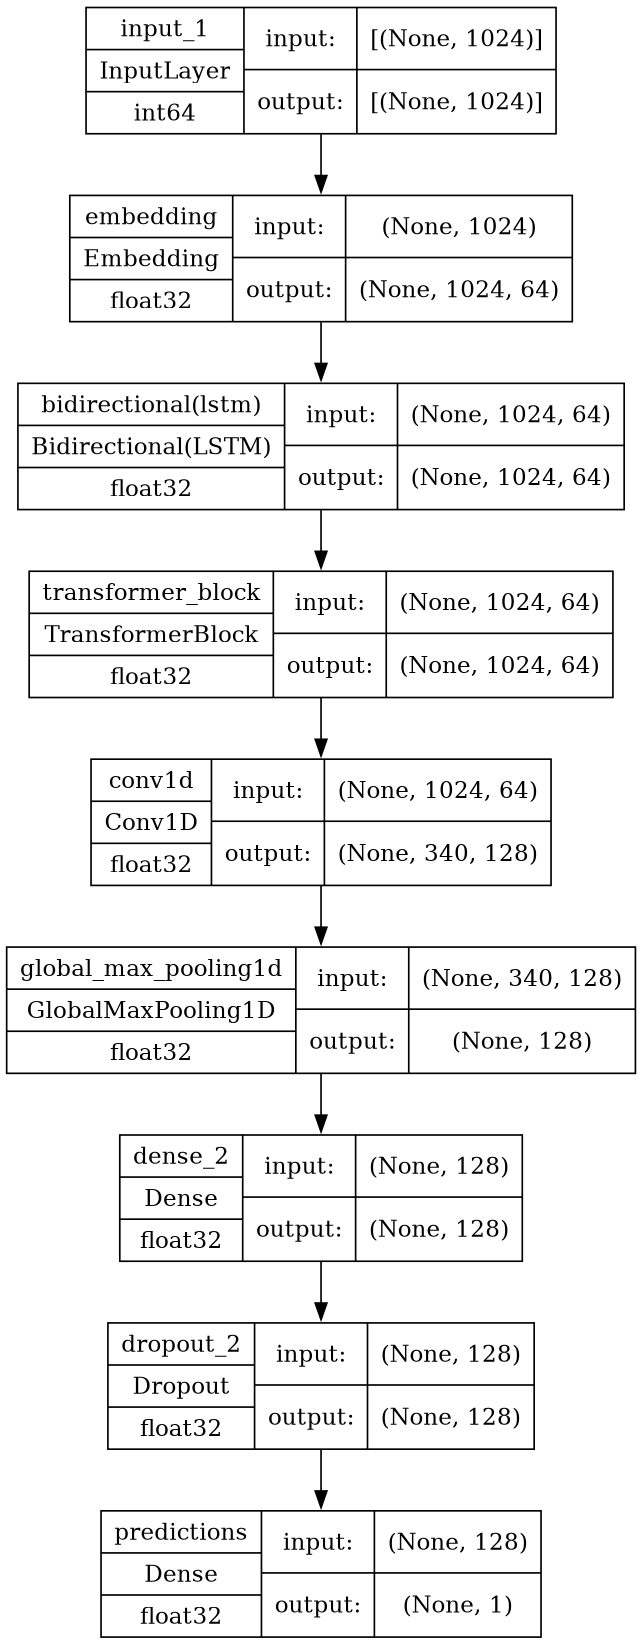

In [25]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [26]:
checkpoint_cb =ModelCheckpoint("model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=10, validation_split=.1, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
304/304 [==============================] - 97s 283ms/step - loss: 0.1273 - accuracy: 0.9496 - val_loss: 0.0199 - val_accuracy: 0.9917
Epoch 2/10
304/304 [==============================] - 78s 256ms/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.0404 - val_accuracy: 0.9880
Epoch 3/10
304/304 [==============================] - 71s 233ms/step - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0460 - val_accuracy: 0.9907
Epoch 4/10
304/304 [==============================] - 64s 211ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.0212 - val_accuracy: 0.9907


**<a id="11"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Evaluation</p>
<a class="btn" href="#home">Tabel of Contents</a>

In [27]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.127258,0.949625,0.019851,0.991674
1,0.008398,0.997121,0.040408,0.987974
2,0.006050,0.998149,0.046024,0.990749
3,0.005541,0.998972,0.021248,0.990749


In [28]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

85/85 [==============================] - 3s 40ms/step - loss: 0.0183 - accuracy: 0.9937
Test Loss = 0.01834024488925934
Test Accuracy = 0.9937083721160889


In [29]:
predictions = model.predict(X_test)
y_pred = np.where(predictions>=.5,1,0)
y_test_1d = np.ravel(y_test)
y_pred_1d = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test_1d, 'Prediction': y_pred_1d})
df

85/85 [==============================] - 4s 37ms/step


,Actual,Prediction
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
2697,0,0
2698,1,1
2699,0,0
2700,1,1


array([[1346,    5],
       [  12, 1339]])

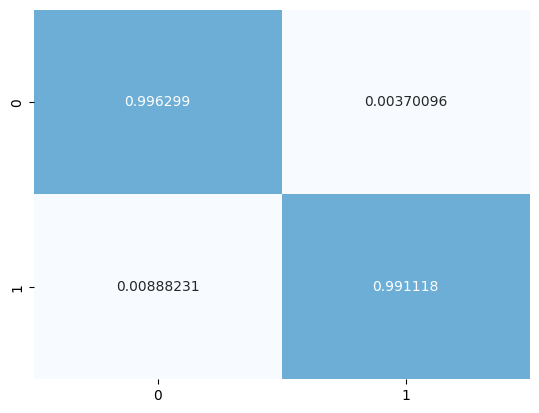

In [30]:
CM = confusion_matrix(y_test_1d,y_pred_1d)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [31]:
ClassificationReport = classification_report(y_test_1d,y_pred_1d)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      1.00      0.99      1351
           1       1.00      0.99      0.99      1351

    accuracy                           0.99      2702
   macro avg       0.99      0.99      0.99      2702
weighted avg       0.99      0.99      0.99      2702



**<a id="12"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Submission</p>
<a class="btn" href="#home">Tabel of Contents</a>

In [32]:
test_text = vectorize_layer(test['text']).numpy()
predictions = model.predict(test_text)
y_pred = np.where(predictions>=.5,1,0)
sub=pd.DataFrame()
sub['id'],sub['generated']=test['id'],predictions
sub.to_csv('/kaggle/working/submission.csv', index=False)
sub

1/1 [==============================] - 0s 107ms/step


,id,generated
0,0000aaaa,0.965493
1,1111bbbb,0.965493
2,2222cccc,0.965493
